In [1]:
import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from math import sqrt


In [2]:
#Data comes from https://www.wunderground.com/history/daily/us/tn/louisville/KTYS/date/2023-4-19
df = pd.read_csv('tn_weather_csv.csv')
print(df.shape)
display(df.head())

(10481, 11)


,Date,Time,Temperature (F),Dew Point (F),Humidity (%),Wind,Wind Speed (mph),Wind Gust (mph),Pressure (in),Precip. (in),Condition
0,4/19/2024,12:53:00 AM,68,59,73,SSW,8,0,28.95,0.0,Fair
1,4/19/2024,1:53:00 AM,67,59,76,S,5,0,28.94,0.0,Partly Cloudy
2,4/19/2024,2:53:00 AM,67,59,76,SSW,6,0,28.92,0.0,Fair
3,4/19/2024,3:53:00 AM,67,60,79,SW,7,0,28.91,0.0,Partly Cloudy
4,4/19/2024,4:53:00 AM,68,62,81,WSW,10,0,28.93,0.0,Mostly Cloudy


## Cleaning the data

In [3]:
df = df.drop(['Date','Time','Wind','Wind Speed (mph)','Wind Gust (mph)','Pressure (in)','Precip. (in)','Condition'], axis=1)
df.reset_index(inplace=True, drop=True)

print(df.shape)
display(df)

(10481, 3)


,Temperature (F),Dew Point (F),Humidity (%)
0,68,59,73
1,67,59,76
2,67,59,76
3,67,60,79
4,68,62,81
...,...,...,...
10476,75,42,31
10477,72,42,34
10478,71,41,34
10479,69,42,38


## Deciding on scores for probability of opening the window

In [4]:
hot_outside_temp = 70
cold_outside_temp = 60
low_humidity = 30
high_humidity = 50
good_dew = 55
sticky_dew = 65

def score_temp(row):
    if row['Temperature (F)'] < cold_outside_temp:
        score = -0.50
    elif row['Temperature (F)'] >= cold_outside_temp and row['Temperature (F)'] < hot_outside_temp:
        score = -0.25
    else:
        score = 0.0
    t_score = (row['Temperature (F)'] / 100 + score) / 2
    return t_score

#less than or equal to 55: dry and comfortable
#between 55 and 65: becoming "sticky" with muggy evenings
#greater than or equal to 65: lots of moisture in the air, becoming oppressive
def score_dew_point(row):
    if row['Dew Point (F)'] <= good_dew:
        score = 0.0
    elif row['Dew Point (F)'] > good_dew and row['Dew Point (F)'] < sticky_dew:
        score = -0.25
    else:
        score = -0.5
    d_score = (row['Dew Point (F)'] / 100 + score) / 2
    return d_score

def score_humidity(row):
    if row['Humidity (%)'] < low_humidity or row['Humidity (%)'] > high_humidity:
        score = -0.25
    else:
        score = 0.0
    h_score = (row['Humidity (%)'] / 100 + score) / 2
    return h_score


df['Likelihood of Opening Window'] = df.apply(score_temp, axis=1)
df['Likelihood of Opening Window'] += df.apply(score_dew_point, axis=1)
df['Likelihood of Opening Window'] += df.apply(score_humidity, axis=1)
df['Likelihood of Opening Window'] = df['Likelihood of Opening Window'].clip(lower=0, upper=1)
display(df.head(30))

,Temperature (F),Dew Point (F),Humidity (%),Likelihood of Opening Window
0,68,59,73,0.625
1,67,59,76,0.635
2,67,59,76,0.635
3,67,60,79,0.655
4,68,62,81,0.680
5,67,63,87,0.710
6,67,64,90,0.730
7,66,64,93,0.740
8,66,64,93,0.740
9,66,65,96,0.635


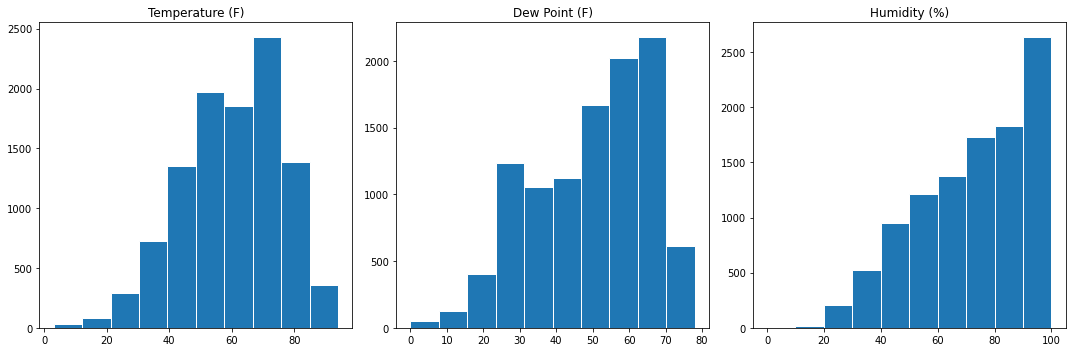

In [5]:
col = ['Temperature (F)', 'Dew Point (F)','Humidity (%)']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, column in enumerate(col):
    temp_df = pd.DataFrame(df[column], columns=[column])
    ax = axes[i]  
    ax.hist(temp_df[column], edgecolor='white')  
    ax.set_title(column)     

plt.tight_layout()  
plt.show()         

## Train and test model

In [6]:
data_df = df.drop('Likelihood of Opening Window', axis=1)
target_df = pd.DataFrame(df['Likelihood of Opening Window'], columns=['Likelihood of Opening Window'])

x_train, x_test, y_train, y_test = train_test_split(data_df, target_df, test_size=0.2, random_state=69)
print(x_train.shape)
print(x_test.shape)

(8384, 3)
(2097, 3)


## Standardizing data

In [7]:
col = ['Temperature (F)', 'Dew Point (F)', 'Humidity (%)']
feature_scaler = RobustScaler()
feature_scaler.fit_transform(x_train[col])
feature_scaler.fit_transform(x_test[col])
df_x_train_standardized = pd.DataFrame(x_train, columns = col)
df_x_test_standardized = pd.DataFrame(x_test, columns = col)

target_scaler = RobustScaler()
target_scaler.fit_transform(y_train)
target_scaler.fit_transform(y_test)
df_y_train_standardized = pd.DataFrame(y_train, columns = ['Likelihood of Opening Window'])
df_y_test_standardized = pd.DataFrame(y_test, columns = ['Likelihood of Opening Window'])

x_train[col] = df_x_train_standardized
x_test[col] = df_x_test_standardized
y_train = df_y_train_standardized
y_test = df_y_test_standardized


<Axes: >

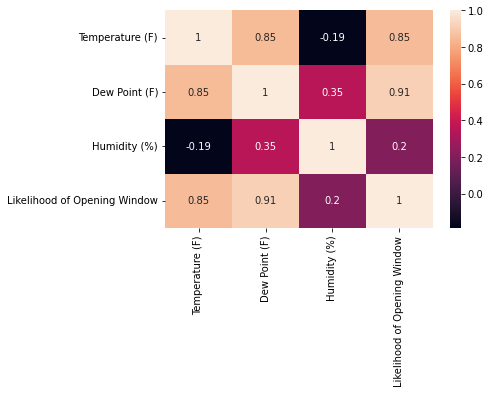

In [8]:
#Negative correlations (when one variable increases, the other variable tends to decrease)
sns.heatmap(pd.concat([df_x_train_standardized, y_train], axis=1).corr(), annot=True)

In [9]:
lm = linear_model.LinearRegression()
model = lm.fit(x_train, y_train)
predictions = lm.predict(x_train)
y_train_pred = pd.DataFrame(predictions, columns=['Predicted Likelihood of Opening Window'])

# Mean Squred Error
mse = mean_squared_error(y_train, y_train_pred)
print('Mean squared error(Train) :', round(mse, 4))

# Root Mean Squared Error
rmsq = sqrt(mean_squared_error(y_train, y_train_pred))
print('Root mean squared error(Train) :', round(rmsq, 4))

# Accuracy
score = lm.score(x_train, y_train)
print('Explained variance of the predictions(Train) :', round(score * 100, 4))

Mean squared error(Train) : 0.0045
Root mean squared error(Train) : 0.0673
Explained variance of the predictions(Train) : 86.6714


In [10]:
predictions = lm.predict(x_test)
y_pred = pd.DataFrame(predictions, columns=['Predicted Likelihood of Opening Window'])

#Mean Squred Error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error(Testing) :', round(mse, 4))

# Root Mean Squared Error
rmsq = sqrt(mean_squared_error(y_test, y_pred))
print('Root mean squared error(Testing) :', round(rmsq, 4))

# Accuracy
score = lm.score(x_test, y_test)
print('Explained variance of the predictions(Testing) :', round(score * 100, 4))

Mean squared error(Testing) : 0.0044
Root mean squared error(Testing) : 0.0663
Explained variance of the predictions(Testing) : 86.653


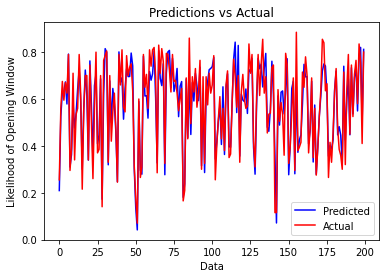

In [11]:
# Plot the first 20 predicted values
plt.plot(y_pred[:200], label='Predicted', color='blue')

# Plot the first 20 actual values
plt.plot(y_test[:200].values, label='Actual', color='red')

# Labeling and title
plt.xlabel('Data')
plt.ylabel('Likelihood of Opening Window')
plt.title('Predictions vs Actual')

# Legend
plt.legend()

# Show the plot
plt.show()


In [12]:
temp = 80
humidity = 50
dew = temp - ((100 - humidity)/5.0)
new_data = pd.DataFrame({
    'Temperature (F)': [temp],
    'Dew Point (F)':[dew],
    'Humidity (%)': [humidity],
})
display(new_data)
prediction = model.predict(new_data)
val = prediction[0].item() * 100.0
print(f"Sarah is {val:.2f}% likely to open the window")

,Temperature (F),Dew Point (F),Humidity (%)
0,80,70.0,50


Sarah is 66.66% likely to open the window


## Read sensor data?

## Comfy check and retrain model
- It would be cool if it asks if I'm comfortable (like a voice). If not, it's going to do something
- Instead of button dictating temperature preference, make button be less controlling
- Look into getting sensors data to the notebook - getting data and retraining the model with it?

In [13]:
import time
import keyboard
from tqdm.notebook import tqdm
# Counter to track retraining frequency
retrain_counter = 0
retrain_frequency = 3  
minutes = 1


while True:
    temp = float(input("No sensor. Enter temperature (F): "))  # Replace with sensor data
    humidity = float(input("No sensor. Enter humidity (%): "))  # Replace with sensor data
    dew = temp - ((100 - humidity) / 5.0)
    new_data = pd.DataFrame({
        'Temperature (F)': [temp],
        'Dew Point (F)': [dew],
        'Humidity (%)': [humidity],
    })
    display(new_data)
    
    # Predict comfort level
    prediction = model.predict(new_data)
    new_data['Likelihood of Opening Window'] = prediction[0]
    val = prediction[0].item()
    print(f"I am {val*100.0:.2f}% likely to open the window")
    
    # Display progress bar for waiting - gives time for window to adjust
    print("Window is now adjusting. Press 'q' to end the sleep time early.")
    for _ in tqdm(range(int(60)), desc="Waiting"):
        if keyboard.is_pressed('q'): 
            break
        time.sleep(1)  
    

    # Ask for user feedback
    response = input("\nAre you comfortable? (yes/no/exit): ").lower()
    if response == 'no':
        val *= 0.9  #Decrease likelihood
        retrain_counter += 1
        minutes = 1
        # Append new data to existing dataset
        x_train = pd.concat([x_train, new_data.drop(columns=['Likelihood of Opening Window'])])
        y_train = pd.concat([y_train, new_data['Likelihood of Opening Window'] * val])
        # Retrain the model if retrain frequency is reached
        if retrain_counter == retrain_frequency:
            lm = linear_model.LinearRegression()
            model = lm.fit(x_train, y_train)  # Retrain the model
            print("I retrained my model to better suit your preferences.")
            retrain_counter = 0  # Reset the counter
        print(f"Adjusted likelihood: {val*100.0:.2f}")
    elif response == 'yes':
        print("Understood. I will keep the window the same and check back later.")
        minutes += 1
    elif response == 'exit':
        print("Understood. I will shut off.")
        break
    else:
        print("Invalid input. I will stay put.")
    
    #Wait time to let window chill
    print("Press 'q' to end the sleep time early.")
    for _ in tqdm(range(int(minutes * 60)), desc="Waiting"):
        if keyboard.is_pressed('q'): 
            break
        time.sleep(1)

ValueError: could not convert string to float: ''